In [1]:
import pandas as pd
import spacy
import numpy as np
import string
from sklearn.naive_bayes import MultinomialNB

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [3]:
# Split data into features and target
X = train_data['Text']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (18000,) Test shape: (4501,)


In [15]:
nlp = spacy.load("en_core_web_sm")
class SyntacticFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for text in X:
            doc = nlp(text)
            # Feature 1: Sentence length (number of tokens)
            sentence_length = len(doc)
            # Feature 2: Punctuation count
            punctuation_count = sum(1 for token in doc if token.text in string.punctuation)
            # Feature 3: Count of nouns, verbs, adjectives
            noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
            verb_count = sum(1 for token in doc if token.pos_ == "VERB")
            adj_count = sum(1 for token in doc if token.pos_ == "ADJ")
            features.append([sentence_length, punctuation_count, noun_count, verb_count, adj_count])
        return np.array(features)

# Custom transformer to extract named entity features
class NamedEntityFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.entity_types = ['PERSON', 'ORG', 'GPE', 'DATE', 'MONEY', 'CARDINAL', 'NORP', 'PERCENT']
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for text in X:
            doc = nlp(text)
            # Total number of entities in the sentence
            total_entities = len(doc.ents)
            # Count of specific entity types
            type_counts = {etype: 0 for etype in self.entity_types}
            for ent in doc.ents:
                if ent.label_ in type_counts:
                    type_counts[ent.label_] += 1
            # Combine features: total entities + counts for each type
            feature_row = [total_entities] + [type_counts[etype] for etype in self.entity_types]
            features.append(feature_row)
        return np.array(features)

# Combine TF-IDF features with syntactic and named entity features
combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 3))),
    ('syntactic', SyntacticFeaturesExtractor()),
    ('entities', NamedEntityFeaturesExtractor())
])

In [16]:
X_train_combined_features = combined_features.fit_transform(X_train)
X_val_combined_features = combined_features.transform(X_val)


In [67]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_combined_features_oversampled, y_train_oversampled = smote.fit_resample(X_train_combined_features, y_train)
smote_class_counts = y_train_oversampled.value_counts().sort_index()
print(f"Class -1: {smote_class_counts.get(-1, 0)} samples")
print(f"Class 0: {smote_class_counts.get(0, 0)} samples")
print(f"Class 1: {smote_class_counts.get(1, 0)} samples")

Class -1: 11759 samples
Class 0: 11759 samples
Class 1: 11759 samples


In [79]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train_combined_features_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_combined_features, y_train)

# Count the number of samples in each class after undersampling
undersample_class_counts = y_train_undersampled.value_counts().sort_index()
print(f"Class -1: {undersample_class_counts.get(-1, 0)} samples")
print(f"Class 0: {undersample_class_counts.get(0, 0)} samples")
print(f"Class 1: {undersample_class_counts.get(1, 0)} samples")

Class -1: 1901 samples
Class 0: 1901 samples
Class 1: 1901 samples


In [80]:
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_combined_features_undersampled, y_train_undersampled)

MultinomialNB(alpha=0.1)

In [81]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


# Evaluate the model
y_pred = nb.predict(X_val_combined_features)

# Calculate metrics
validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_weighted = f1_score(y_val, y_pred, average='weighted')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"Weighted F1 Score: {validation_f1_weighted:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.88      0.71      0.79      2926
           0       0.29      0.59      0.38       502
           1       0.59      0.60      0.60      1073

    accuracy                           0.67      4501
   macro avg       0.58      0.63      0.59      4501
weighted avg       0.74      0.67      0.70      4501

Accuracy: 0.6721
Macro F1 Score: 0.5889
Weighted F1 Score: 0.6965
F1 Score per class:
  Not Factual: 0.7872
  Unimportant Fact: 0.3847
  Important Fact: 0.5950


In [82]:
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_combined_features_oversampled, y_train_oversampled)

# Evaluate the model
y_pred = nb.predict(X_val_combined_features)

# Calculate metrics
validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_weighted = f1_score(y_val, y_pred, average='weighted')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"Weighted F1 Score: {validation_f1_weighted:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.87      0.75      0.81      2926
           0       0.30      0.49      0.37       502
           1       0.59      0.62      0.61      1073

    accuracy                           0.69      4501
   macro avg       0.59      0.62      0.60      4501
weighted avg       0.74      0.69      0.71      4501

Accuracy: 0.6943
Macro F1 Score: 0.5957
Weighted F1 Score: 0.7118
F1 Score per class:
  Not Factual: 0.8083
  Unimportant Fact: 0.3707
  Important Fact: 0.6079


Confusion matrix saved as 'confusion_matrix.png'


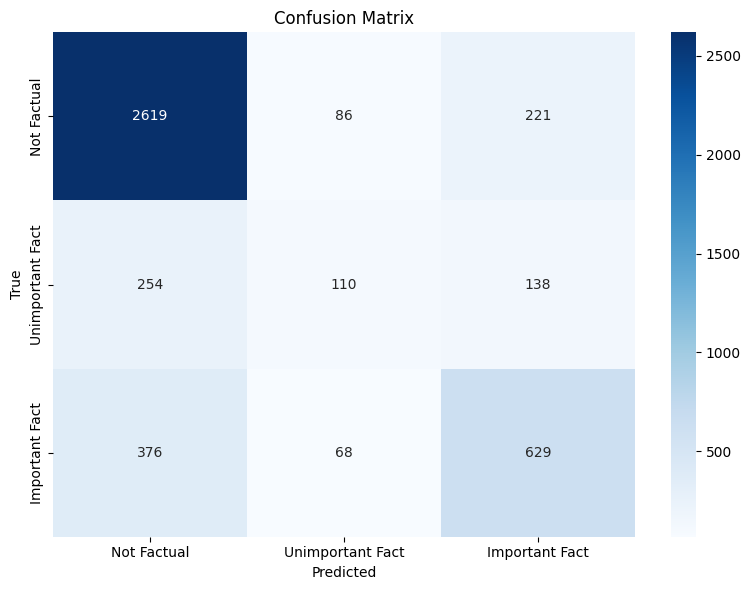

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [38]:
import joblib

pipeline = Pipeline([
    ('features', combined_features),
    ('NB', nb)
])
joblib.dump(pipeline, 'features_tfidf_NB_model.pkl')
print("Model saved as 'features_tfidf_NB_model.pkl'")

Model saved as 'features_tfidf_NB_model.pkl'


In [39]:

# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    
    # Make predictions
    predictions = model.predict(test_data['Text'])
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('features_tfidf_NB_model.pkl', 'data/test.csv', 'data/features_tfidf_NB_predictions.csv')


Making predictions on test data...
Predictions saved to data/features_tfidf_NB_predictions.csv
